In [1]:
import cv2
import numpy as np
import os
import random
import torch
import pickle

from bs4 import BeautifulSoup
from shapely.geometry import Polygon
from uuid import uuid4

from skimage.measure import label, regionprops
from skimage.feature import local_binary_pattern
from skimage.filters import threshold_multiotsu
from matplotlib import pyplot as plt
from PIL import Image
from torchmetrics.classification import BinaryJaccardIndex
from torchmetrics.detection.mean_ap import MeanAveragePrecision

from deeplab_vandaele import remove_non_river
from mask_rcnn_coco import remove_boats
from utils import get_device, load_image, preprocessing

In [2]:
device = get_device()

Device: NVIDIA GeForce RTX 3070 Laptop GPU


In [38]:
imgs = [
    'images/images/868df0899e668.jpg',
    'images/images/1cfecac9fd128.jpg',
    'images/images/2d43805e5efd4.jpg',
    'images/images/3cde210a9022e.jpg',
    'images/images/1eb0743881e5f.jpg',
    'images/images/1cfecac9fd128.jpg'
]
for a, b, c in os.walk('images/images'):
    for filename in random.sample(c, 4):
        if('.jpg' in filename):
            print('%s/%s' % (a, filename))
            # import images as grayscale 1D of ints ranging 0 - 255 (intensity) 
            imgs.append('%s/%s' % (a, filename))
print(len(imgs))

images/images/098a1d68568bc.jpg
images/images/83a4f8745459a.jpg
images/images/98e2c880176d9.jpg
images/images/58b5b3e109391.jpg
10


In [4]:
images = []
for img_path in imgs:
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, dsize=(640, 360), interpolation= cv2.INTER_LINEAR)
    img, raw_img = load_image(img_path, device)
    removed_river_image, _ = remove_non_river(img, raw_img, device)
    removed_boat_image, _ = remove_boats(removed_river_image, device)
    
    images.append({
        'filename': img_path, 
        "original": image, 
        'removed_river': removed_river_image, 
        'removed_boat': removed_boat_image
    })
    
len(images)

C:\Users\chris\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
C:\Users\chris\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights_backbone=None`.
  warnings.warn(msg)


torch.Size([3, 360, 640])
torch.Size([3, 360, 640])
torch.Size([3, 360, 640])
torch.Size([3, 360, 640])
torch.Size([3, 360, 640])
torch.Size([3, 360, 640])
torch.Size([3, 360, 640])
torch.Size([3, 360, 640])
torch.Size([3, 360, 640])
torch.Size([3, 360, 640])


10

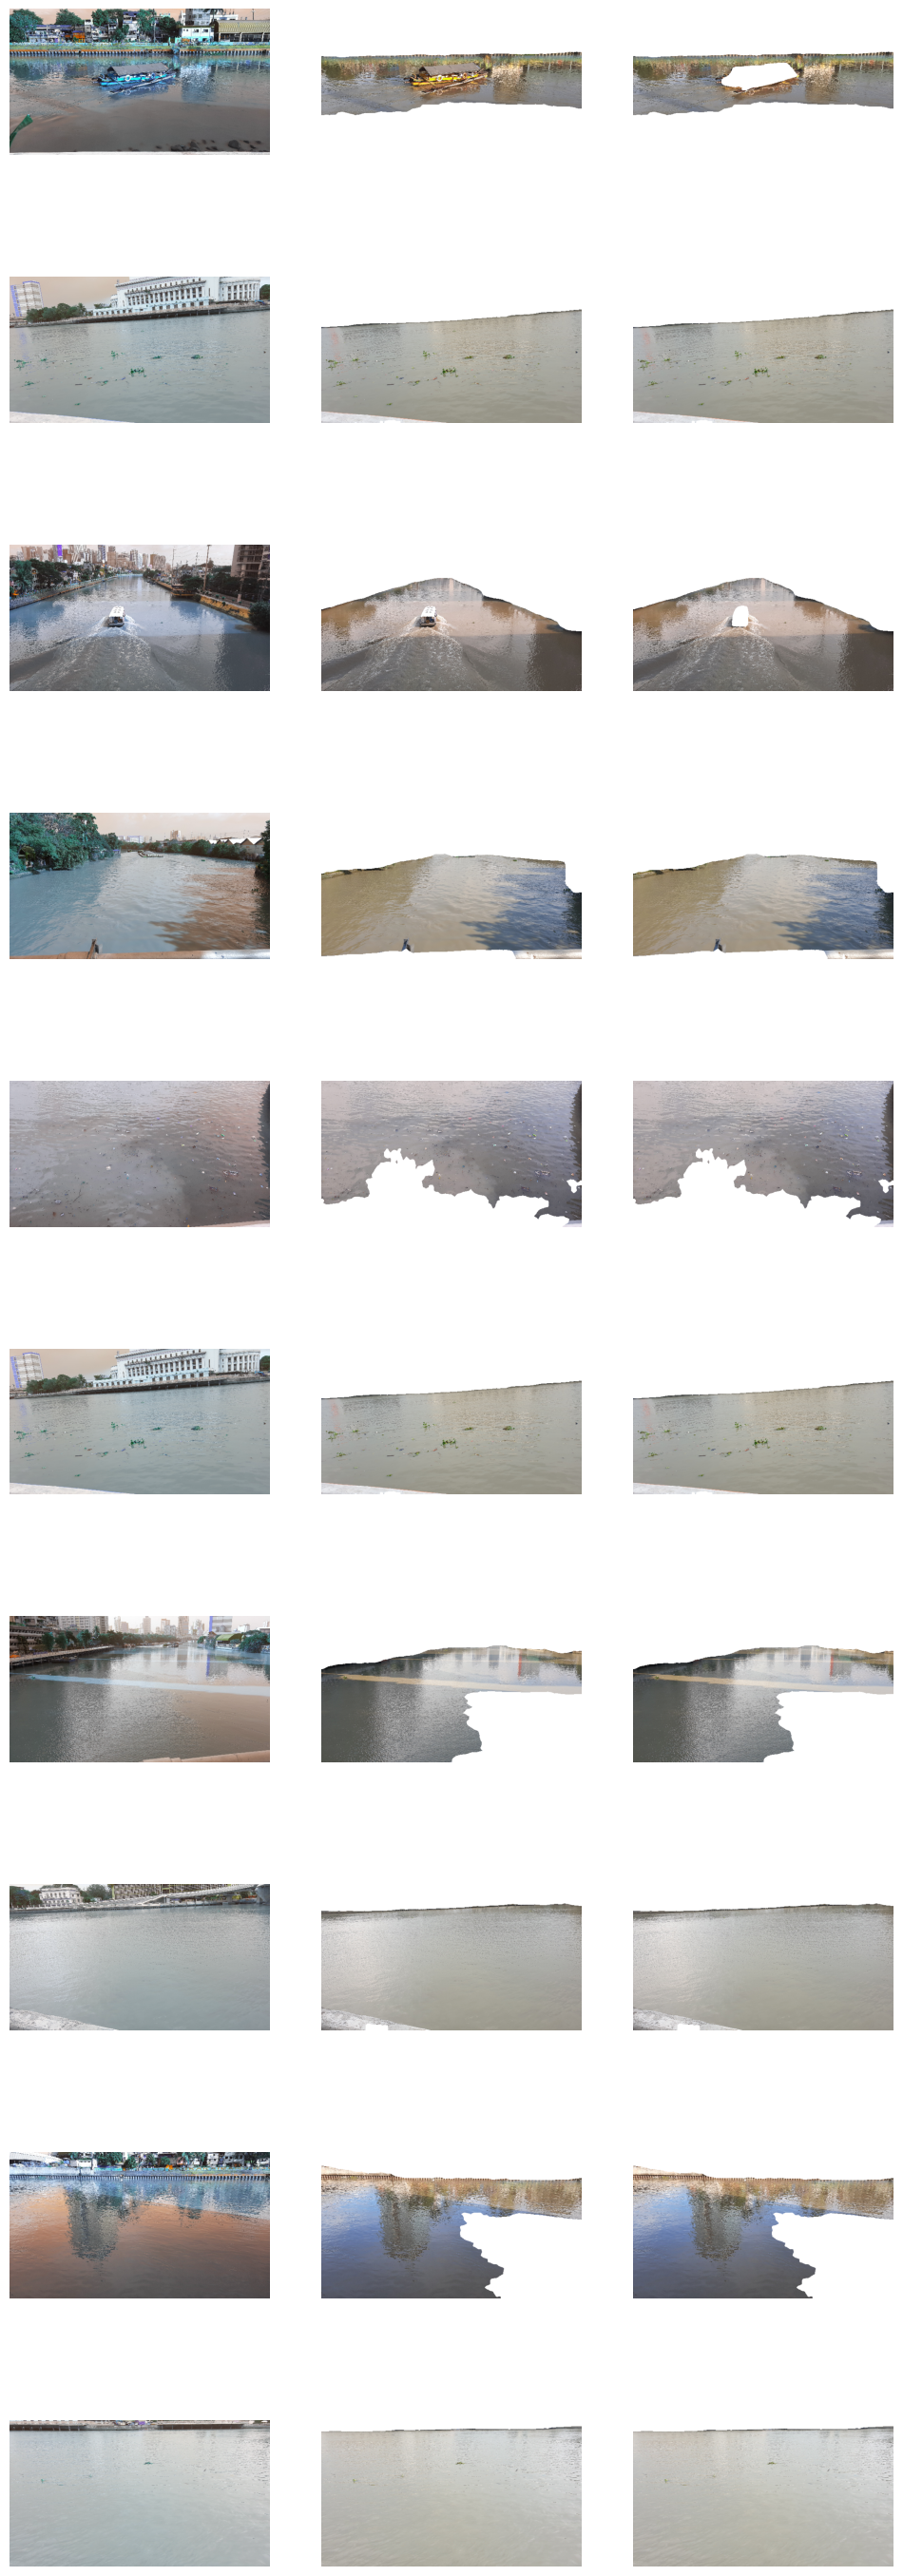

In [5]:
f, axarr = plt.subplots(len(imgs), 3, figsize=(12, 36))

for r in range(len(imgs)):
    axarr[r, 0].imshow(images[r]['original'])
#     axarr[row, 0].set_title(images[row]['filename'])
        
    axarr[r, 1].imshow(images[r]['removed_river'])
#     axarr[row, 1].set_title("river removed")
        
    axarr[r, 2].imshow(images[r]['removed_boat'])
#     axarr[row, 2].set_title("boat removed")

    axarr[r, 0].axis('off')
    axarr[r, 1].axis('off')
    axarr[r, 2].axis('off')

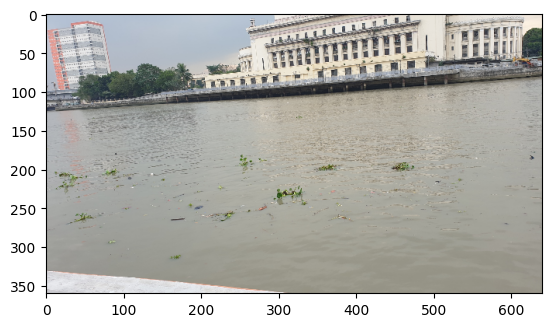

In [60]:
img, raw_img = load_image(imgs[1], device)
plt.imshow(raw_img)

C:\Users\chris\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
C:\Users\chris\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights_backbone=None`.
  warnings.warn(msg)


torch.Size([3, 360, 640])


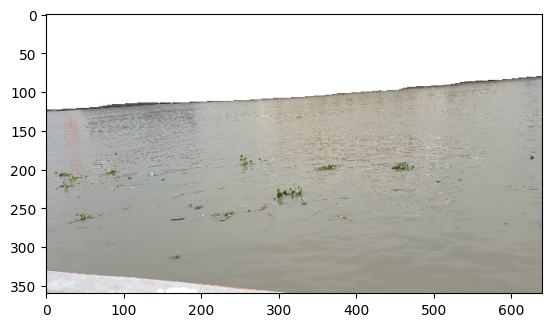

In [61]:
removed_river_image, river_mask = remove_non_river(img, raw_img, device)
removed_boat_image, boat_masks = remove_boats(removed_river_image, device)

plt.imshow(removed_boat_image)

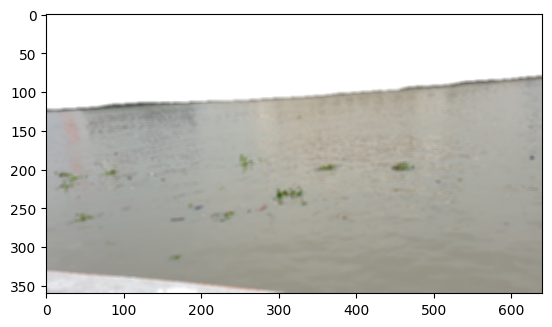

In [44]:
blur = cv2.blur(removed_boat_image,(5, 5))

plt.imshow(blur)

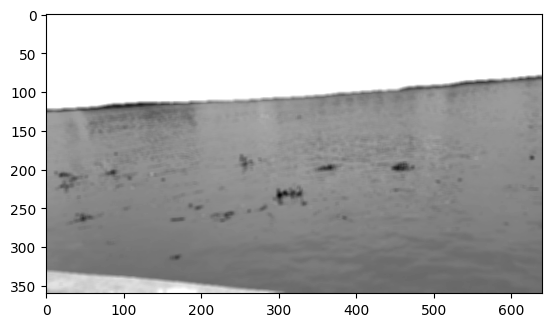

In [45]:
img_gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
height, width = img_gray.shape

plt.imshow(img_gray, cmap ="gray")

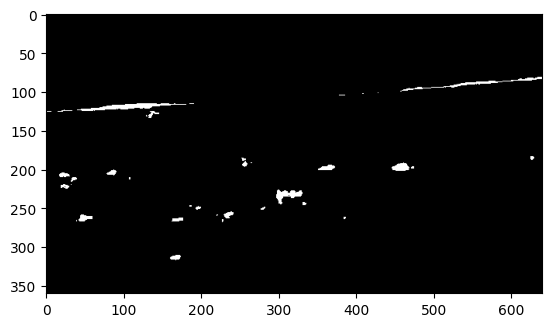

In [46]:
kernel = np.ones((5,5),np.uint8)

_, threshold = cv2.threshold(img_gray, 138, 255, cv2.THRESH_BINARY_INV)

plt.imshow(threshold, cmap='gray')

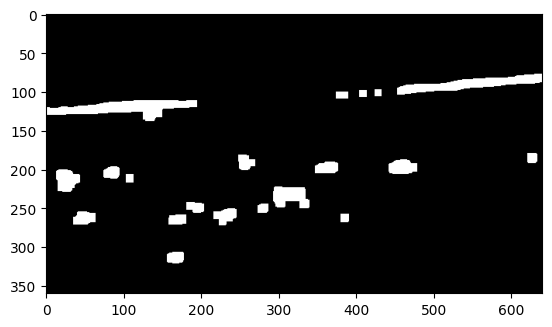

In [47]:
# Noise removal using Morphological open operation
kernel = np.ones((5,5),np.uint8)
morphOpen = cv2.dilate(threshold, kernel, iterations=2)
morphClose = cv2.morphologyEx(morphOpen, cv2.MORPH_CLOSE, kernel, iterations=1)
morphOpen = cv2.morphologyEx(morphClose, cv2.MORPH_OPEN, kernel, iterations=1)

plt.imshow(morphOpen, cmap='gray')

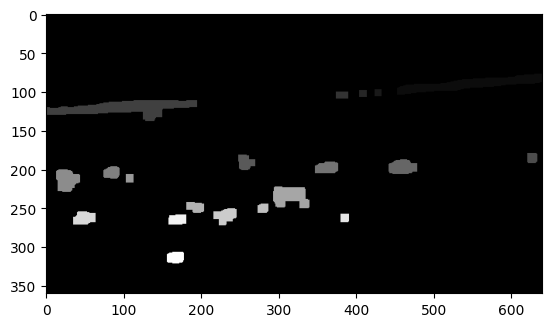

In [48]:
from skimage.measure import label, regionprops

label_im = label(morphOpen)
plt.imshow(label_im, cmap='gray')

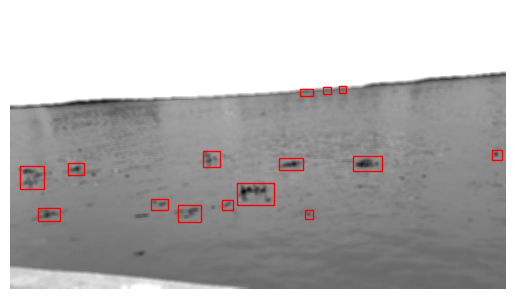

In [49]:
fig, ax = plt.subplots()
plt.imshow(img_gray, cmap='gray')

labels = regionprops(label_im)

for i in labels:
    minr, minc, maxr, maxc = i.bbox
    if(sum(sum(img_gray[minr:minr+maxr, minc:minc+maxc] == 255)) <= 100):
        rect = plt.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=1)

        ax.add_patch(rect)
ax.set_axis_off()
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

In [50]:
# metadata = {
#     'filename': [],
#     'type': [],
# }

NameError: name 'metadata' is not defined

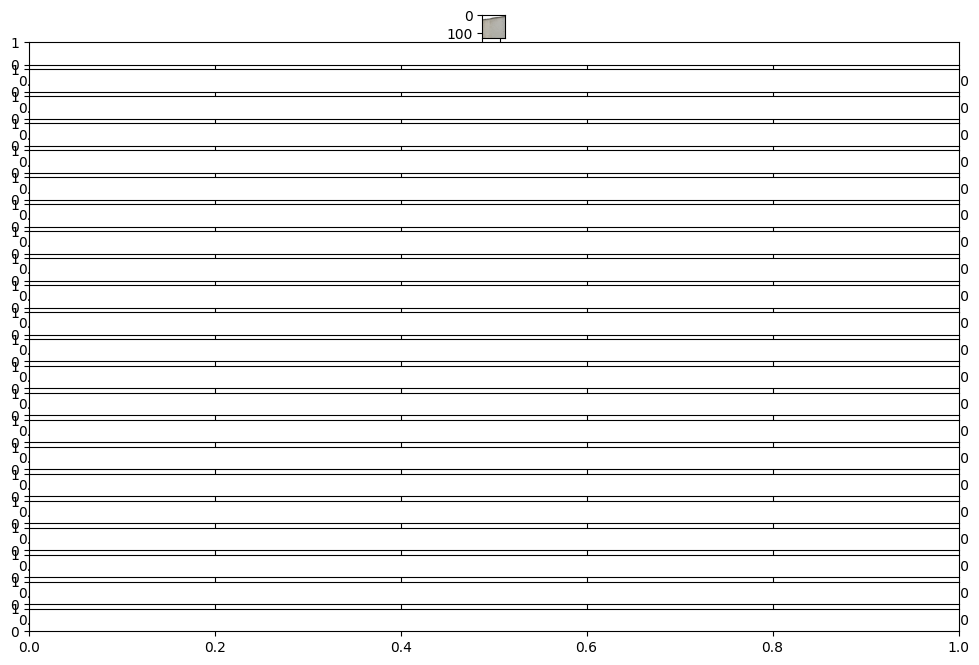

In [41]:
f, axarr = plt.subplots(len(labels), 1, figsize=(12, 8))

for i in range(len(labels)):
    minr, minc, maxr, maxc = labels[i].bbox
    area = (maxr - minr) * (maxc - minc)
    if(area > 50):
        filename = '%s/images/misclassified/%s.jpg' % (os.getcwd(), uuid4())
        
        new_img = cv2.resize(removed_boat_image[minr:minr+maxr, minc:minc+maxc].copy(), dsize=(128, 128), interpolation=cv2.INTER_LINEAR)
        axarr[i].imshow(new_img)
        
        result = cv2.imwrite(filename, new_img)
        
        if(result):
            metadata['filename'].append(filename)
            metadata['type'].append('misclassified')

In [42]:
import pandas as pd

new_df = pd.DataFrame(metadata)

new_df.head()

NameError: name 'metadata' is not defined

In [155]:
len(new_df)

45

In [156]:
new_df.to_csv('misclassified_metadatas.csv', index=False)

## Anomaly Detection

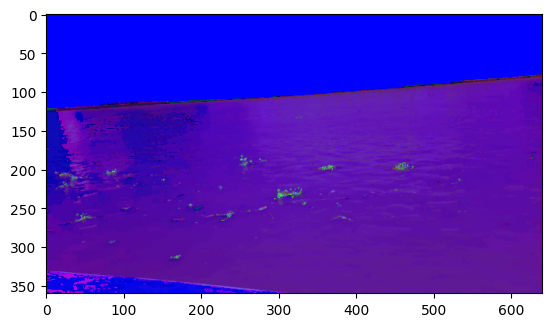

In [48]:
plt.imshow(new_img)

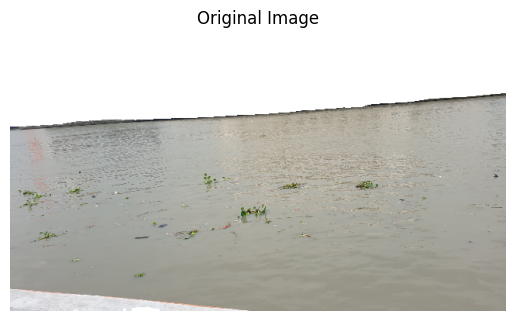

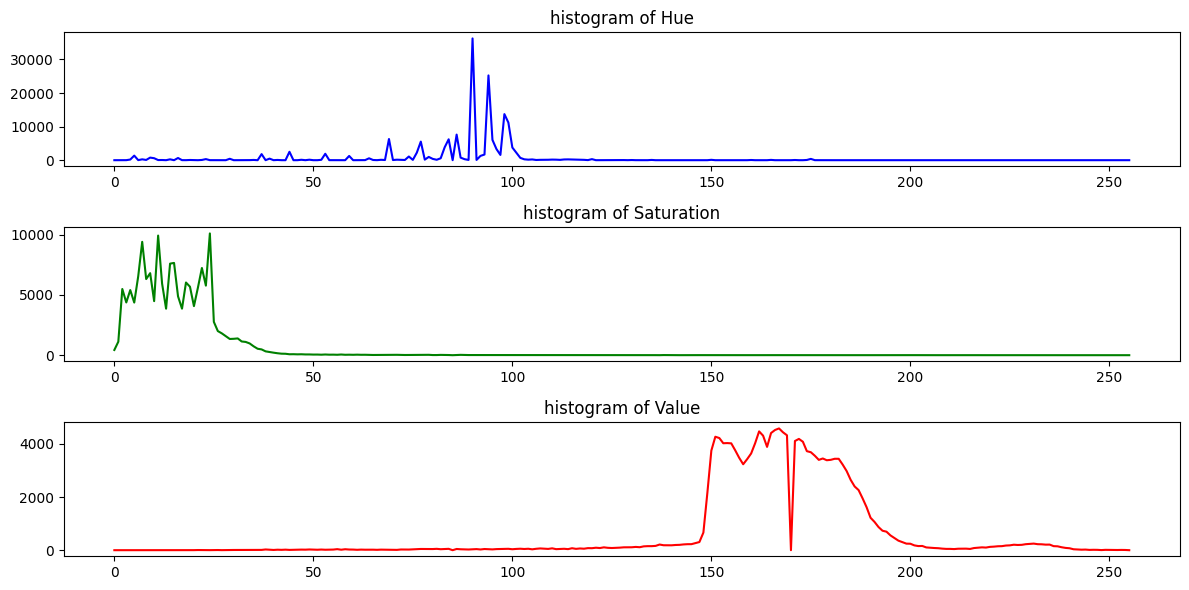

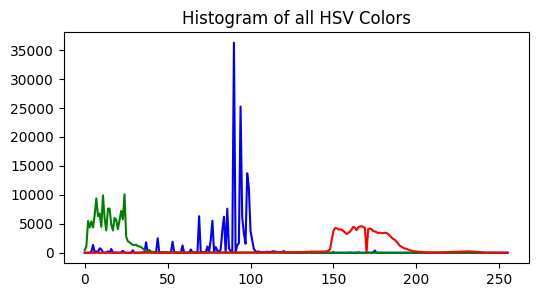

In [43]:
# to avoid grid lines
plt.axis("off")
plt.title("Original Image")
plt.imshow(removed_boat_image, 'hsv')
new_img = cv2.cvtColor(removed_boat_image, cv2.COLOR_BGR2HSV)

# Get RGB data from image
hue = cv2.calcHist([new_img], [0], None, [256], [1, 254])
saturation = cv2.calcHist([new_img], [1], None, [256], [1, 254])
value = cv2.calcHist([new_img], [2], None, [256], [1, 254])

_= plt.figure(figsize=(12, 6))

# Separate Histograms for each color
plt.subplot(3, 1, 1)
plt.title("histogram of Hue")
plt.plot(hue, color="blue")

plt.subplot(3, 1, 2)
plt.title("histogram of Saturation")
plt.plot(saturation, color="green")

plt.subplot(3, 1, 3)
plt.title("histogram of Value")
plt.plot(value, color="red")

# for clear view
plt.tight_layout()

_= plt.figure(figsize=(6, 3))

# combined histogram
plt.title("Histogram of all HSV Colors")
plt.plot(hue, color="blue")
plt.plot(saturation, color="green")
plt.plot(value, color="red")
plt.show()

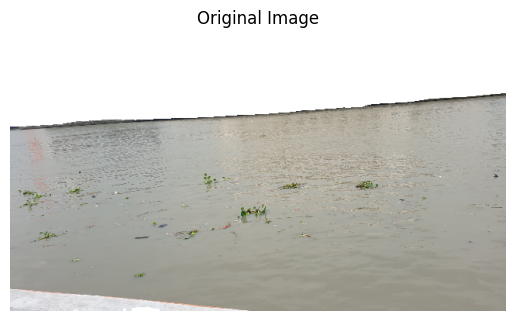

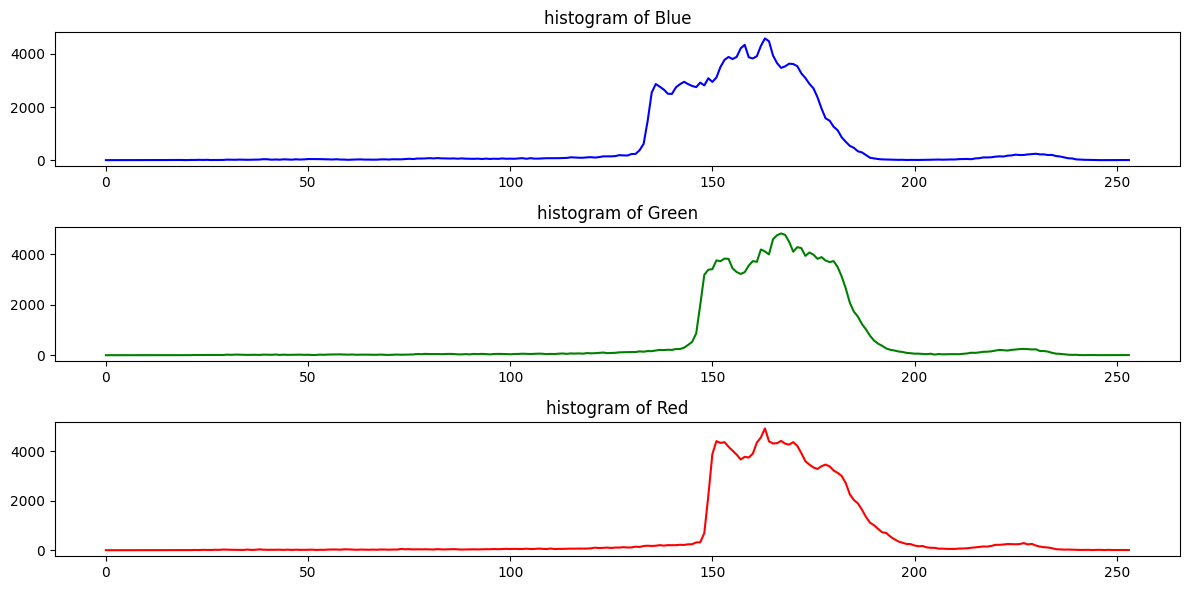

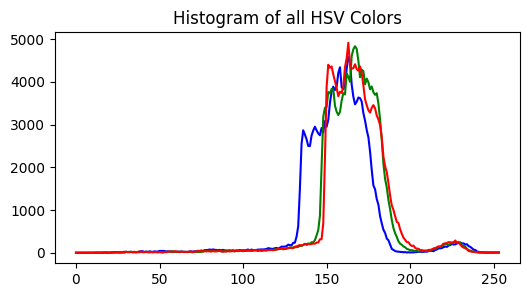

In [44]:
# to avoid grid lines
plt.axis("off")
plt.title("Original Image")
plt.imshow(removed_boat_image)

# Get RGB data from image
red_color = cv2.calcHist([removed_boat_image], [0], None, [254], [0, 254])
green_color = cv2.calcHist([removed_boat_image], [1], None, [254], [0, 254])
blue_color = cv2.calcHist([removed_boat_image], [2], None, [254], [0, 254])

_= plt.figure(figsize=(12, 6))

# Separate Histograms for each color
plt.subplot(3, 1, 1)
plt.title("histogram of Blue")
plt.plot(blue_color, color="blue")

plt.subplot(3, 1, 2)
plt.title("histogram of Green")
plt.plot(green_color, color="green")

plt.subplot(3, 1, 3)
plt.title("histogram of Red")
plt.plot(red_color, color="red")

# for clear view
plt.tight_layout()

_= plt.figure(figsize=(6, 3))

# combined histogram
plt.title("Histogram of all HSV Colors")
plt.plot(blue_color, color="blue")
plt.plot(green_color, color="green")
plt.plot(red_color, color="red")
plt.show()

## Local Binary Pattern

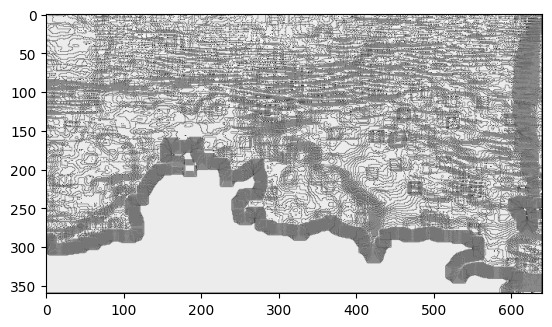

In [8]:
# type of LBP
METHOD = 'uniform'  # at most two circular 0-1 or 1-0 transitions
radius = 1  # distance between central pixels and comparison pixels
n_points = 12 * radius  # define number of comparison pixels

lbp_img = local_binary_pattern(img_gray, n_points, radius, METHOD)
plt.imshow(lbp_img, cmap='gray')

In [170]:
def hist(lbp):
    '''
    Create a histogram
    :param axis: matplotlib axes
    :param lbp: ndarray local binary pattern representation of an image
    :return: matplotliob histogram
    '''
    n_bins = int(lbp.max() + 1) # number of bins based on number of different values in lbp
    return plt.hist(lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins),
                   facecolor='0.5') # np.ravel() returns a flattened 1D array

(array([0.00909288, 0.05198785, 0.14540365, 0.27496528, 0.07895833,
        0.43476997, 0.00482205]),
 array([0., 1., 2., 3., 4., 5., 6., 7.]),
 <BarContainer object of 7 artists>)

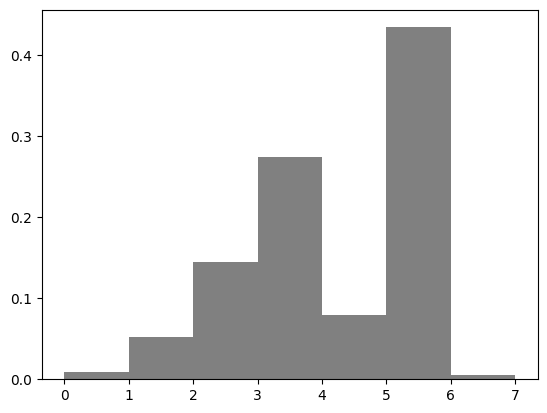

In [171]:
hist(lbp_img)

## Template Matching

In [6]:
df = pd.read_csv('objects_metadata.csv')
df.head()

filename            type
0  C:\Users\chris\OneDrive\Documents\School\Thesi...  water_hyacinth
1  C:\Users\chris\OneDrive\Documents\School\Thesi...  water_hyacinth
2  C:\Users\chris\OneDrive\Documents\School\Thesi...  water_hyacinth
3  C:\Users\chris\OneDrive\Documents\School\Thesi...  water_hyacinth
4  C:\Users\chris\OneDrive\Documents\School\Thesi...         garbage

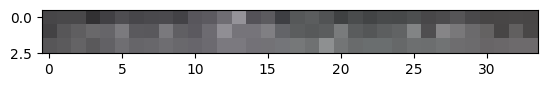

In [36]:
template = cv2.imread(df.iloc[6]['filename'])

plt.imshow(template)

In [23]:
template.shape[::-1]

(3, 26, 6)

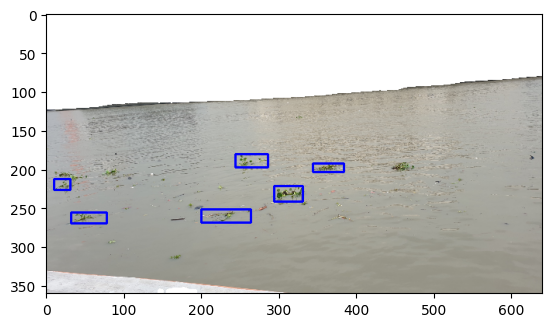

In [61]:
new_img = removed_boat_image.copy()
for i, row in list(df[df['type'] == 'water_hyacinth'].iterrows()):
    template = cv2.imread(row['filename'])
    
    res = cv2.matchTemplate(new_img, template, cv2.TM_CCOEFF_NORMED)

    loc = np.where(res >= 0.8)

    _, w, h = template.shape[::-1]
    
    if(w > 10 and h > 10):
        for pt in zip(*loc[::-1]):
            cv2.rectangle(new_img, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)

plt.imshow(new_img)

## Multi-Otsu

In [43]:
# Applying multi-Otsu threshold for the default value, generating  three classes.
thresholds = threshold_multiotsu(img_gray)

# Using the threshold values, we generate the three regions.
regions = np.digitize(img_gray, bins=thresholds)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))

# Plotting the original image.
ax[0].imshow(img_gray)
ax[0].set_title('Original')
ax[0].axis('off')

# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.
ax[1].hist(img_gray.ravel(), bins=255)
ax[1].set_title('Histogram')
for thresh in thresholds:
    ax[1].axvline(thresh, color='r')

# Plotting the Multi Otsu result.
ax[2].imshow(regions, cmap='jet')
ax[2].set_title('Multi-Otsu result')
ax[2].axis('off')

plt.subplots_adjust()

plt.show()

NameError: name 'img_gray' is not defined

## Getting IoU from Ground Truth
1. River Segmentation
2. Boat Removal
3. Detected Surface Objects

In [28]:
images = []
files = ['batch1.xml', 'batch2.xml', 'batch3.xml', 'batch4.xml']

for file in files:
    with open('./segmentations/%s' % file, 'r') as f:
        soup = BeautifulSoup(f.read(), "xml")
        for img in soup.find_all('image'):
            filename = img.get('name')
            
            image = cv2.imread('./images/images/%s' % filename)
            image = cv2.resize(image, dsize=(640, 360), interpolation=cv2.INTER_LINEAR)
            
            height = int(img.get('height'))
            width = int(img.get('width'))
            
            scaleY = 360 / height
            scaleX = 640 / width
            
            river_mask = np.zeros((360, 640))
            object_mask = np.zeros((360, 640))
            water_hyacinth_mask = np.zeros((360, 640))
            garbage_mask = np.zeros((360, 640))
            boat_mask = np.zeros((360, 640))
            
            for polygon in img.find_all('polygon'):
                if(polygon.get('label') == 'river'):
                    coords = np.array([[round(float(p.split(',')[0]) * scaleX), round(float(p.split(',')[1]) * scaleY)] for p in polygon.get('points').split(';')])
                    
                    cv2.drawContours(river_mask, [coords], -1, 1, -1, cv2.LINE_AA)
                elif(polygon.get('label') == 'object'):
                    coords = np.array([[round(float(p.split(',')[0]) * scaleX), round(float(p.split(',')[1]) * scaleY)] for p in polygon.get('points').split(';')])
                    
                    if(polygon.find('attribute').text == 'water hyacinth'):
                        cv2.drawContours(object_mask, [coords], -1, 1, -1, cv2.LINE_AA)
                        cv2.drawContours(water_hyacinth_mask, [coords], -1, 1, -1, cv2.LINE_AA)
                    elif(polygon.find('attribute').text == 'garbage'):
                        cv2.drawContours(object_mask, [coords], -1, 1, -1, cv2.LINE_AA)
                        cv2.drawContours(garbage_mask, [coords], -1, 1, -1, cv2.LINE_AA)
                    elif(polygon.find('attribute').text == 'boat'):
                        cv2.drawContours(boat_mask, [coords], -1, 1, -1, cv2.LINE_AA)
                    elif(polygon.find('attribute').text == 'others'):
                        cv2.drawContours(object_mask, [coords], -1, 1, -1, cv2.LINE_AA)
            
            images.append({
                'name': filename,
                'image': image,
                'river_mask': 1 - river_mask,
                'water_hyacinth_mask': 1 - water_hyacinth_mask,
                'garbage_mask': 1 - garbage_mask,
                'boat_mask': 1 - boat_mask,
                'object_mask': 1 - object_mask,
            })
            
len(images)

360

In [29]:
# save dictionary to pickle file
with open("ground_truth.pkl", "wb") as file:
    pickle.dump(images, file, pickle.HIGHEST_PROTOCOL)

In [3]:
with open("ground_truth.pkl", "rb") as file:
    images = pickle.load(file)
len(images)

360

In [48]:
accuracy_metric = BinaryJaccardIndex()
precision_metric = MeanAveragePrecision()

pred_boat = []
actual_boat = []

pred_obj = []
actual_obj = []

for i, im in enumerate(images[11:13]):
    img, raw_img = preprocessing(im['image'], device)
    
    removed_river_image, river_mask = remove_non_river(img, raw_img, device)
    removed_boat_image, boat_mask = remove_boats(removed_river_image, device)
    
    pred_boxes = torch.Tensor([mask.bbox for mask in regionprops(label(1 - boat_mask))])
    actual_boxes = torch.Tensor([mask.bbox for mask in regionprops(label(1 - im['boat_mask']))])
    
    pred_boat.append(dict(
        boxes=pred_boxes, 
        scores=torch.ones(pred_boxes.shape[0]), 
        labels=torch.zeros(pred_boxes.shape[0])
    ))
    actual_boat.append(dict(
        boxes=actual_boxes, 
        labels=torch.zeros(actual_boxes.shape[0])
    ))
    
    blur = cv2.blur(removed_boat_image,(10, 10))
    img_gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
    
    kernel = np.ones((5,5),np.uint8)
    _, threshold = cv2.threshold(img_gray, 96, 255, cv2.THRESH_BINARY_INV)
    morphOpen = cv2.dilate(threshold, kernel, iterations=2)
    morphClose = cv2.morphologyEx(morphOpen, cv2.MORPH_CLOSE, kernel, iterations=1)
    morphOpen = cv2.morphologyEx(morphClose, cv2.MORPH_OPEN, kernel, iterations=1)
    
    pred_boxes = torch.Tensor([mask.bbox for mask in regionprops(label(morphOpen))])
    actual_boxes = torch.Tensor([mask.bbox for mask in regionprops(label(1 - im['object_mask']))])
    
    pred_obj.append(dict(
        boxes=pred_boxes, 
        scores=torch.ones(pred_boxes.shape[0]), 
        labels=torch.zeros(pred_boxes.shape[0])
    ))
    actual_obj.append(dict(
        boxes=actual_boxes, 
        labels=torch.zeros(actual_boxes.shape[0])
    ))

print(precision_metric(pred_boat, actual_boat))
print(precision_metric(pred_obj, actual_obj))
    
#     images[i]['river_iou'] = float(accuracy_metric(torch.Tensor(1 - river_mask), torch.Tensor(1 - im['river_mask'])))
#     images[i]['predicted_river'] = 1 - river_mask
    
#     print('[%3d] River IoU: %.2f | Boat IoU: %.2f | Objects IoU: %.2f' % (i + 1, images[i]['river_iou'], images[i]['boat_iou'], images[i]['object_iou']))

{'map': tensor(0.9000), 'map_50': tensor(1.), 'map_75': tensor(1.), 'map_small': tensor(-1.), 'map_medium': tensor(0.9000), 'map_large': tensor(-1.), 'mar_1': tensor(0.9000), 'mar_10': tensor(0.9000), 'mar_100': tensor(0.9000), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.9000), 'mar_large': tensor(-1.), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.)}
{'map': tensor(0.), 'map_50': tensor(0.), 'map_75': tensor(0.), 'map_small': tensor(0.), 'map_medium': tensor(-1.), 'map_large': tensor(-1.), 'mar_1': tensor(0.), 'mar_10': tensor(0.), 'mar_100': tensor(0.), 'mar_small': tensor(0.), 'mar_medium': tensor(-1.), 'mar_large': tensor(-1.), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.)}


In [44]:
print('=== River mIoU: %.2f ===' % (sum([a['river_iou'] for a in images]) / 360))
print('=== Boat mIoU: %.2f ===' % (sum([a['boat_iou'] for a in images]) / 360))
print('=== Object mIoU: %.2f ===' % (sum([a['object_iou'] for a in images]) / 360))

=== River mIoU: 0.95 ===
=== Boat mIoU: nan ===
=== Object mIoU: nan ===


In [52]:
boats_iou = [a['boat_iou'] for a in images if a['boat_iou'] == a['boat_iou']]
print(len(boats_iou), sum(boats_iou) / len(boats_iou))

76 0.07573755830526352


In [51]:
objects_iou = [a['object_iou'] for a in images if a['object_iou'] == a['object_iou']]
print(len(objects_iou), sum(objects_iou) / len(objects_iou))

355 0.01427940052612619


## Estimating Size

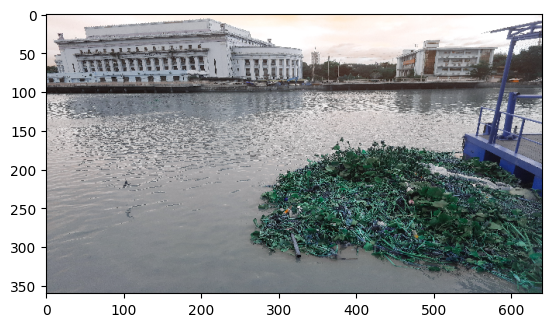

In [5]:
plt.imshow(images[2]['image'])

In [11]:
# model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)
midas.to(device)
midas.eval()

midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in C:\Users\chris/.cache\torch\hub\intel-isl_MiDaS_master


Loading weights:  None


Using cache found in C:\Users\chris/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master
Using cache found in C:\Users\chris/.cache\torch\hub\intel-isl_MiDaS_master


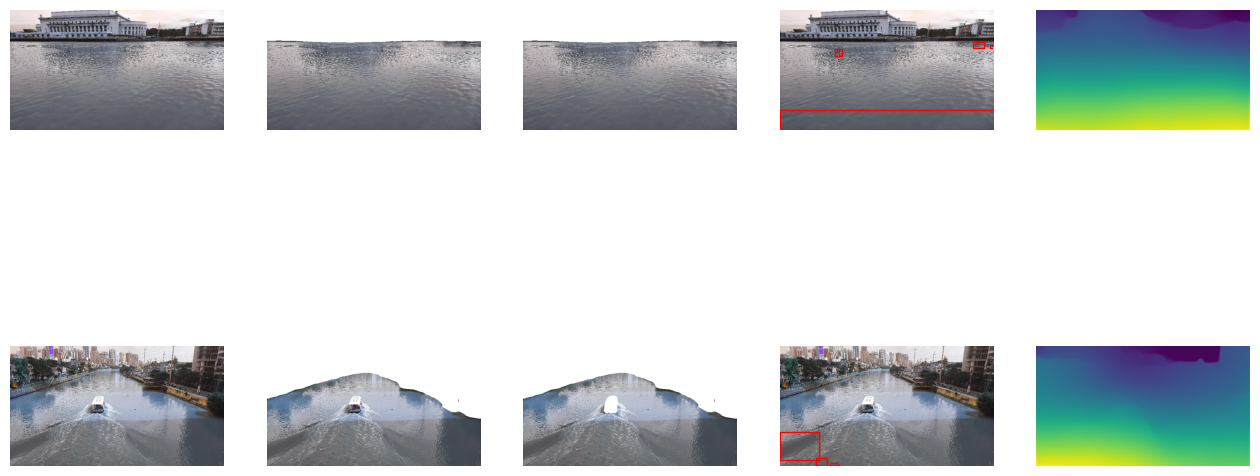

In [29]:
start = 11
end = 13

f, axarr = plt.subplots(end - start, 5, figsize=(16, 8))
for i, im in enumerate(images[start:end]):
    img, raw_img = preprocessing(im['image'], device)
    
    input_batch = transform(raw_img).to(device)

    with torch.no_grad():
        prediction = midas(input_batch)

        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=raw_img.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    output = prediction.cpu().numpy()
    
    removed_river_image, river_mask = remove_non_river(img, raw_img, device)
    removed_boat_image, boat_mask = remove_boats(removed_river_image, device)
    
    axarr[i, 0].imshow(raw_img)
    axarr[i, 1].imshow(removed_river_image)
    axarr[i, 2].imshow(removed_boat_image)
    axarr[i, 3].imshow(raw_img)
    axarr[i, 4].imshow(output)

    axarr[i, 0].axis('off')
    axarr[i, 1].axis('off')
    axarr[i, 2].axis('off')
    axarr[i, 3].axis('off')
    axarr[i, 4].axis('off')
    
    # surface object retrieval part
    blur = cv2.blur(removed_boat_image,(10, 10))
    img_gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
    
    kernel = np.ones((5,5),np.uint8)
    _, threshold = cv2.threshold(img_gray, 96, 255, cv2.THRESH_BINARY_INV)
    morphOpen = cv2.dilate(threshold, kernel, iterations=2)
    morphClose = cv2.morphologyEx(morphOpen, cv2.MORPH_CLOSE, kernel, iterations=1)
    morphOpen = cv2.morphologyEx(morphClose, cv2.MORPH_OPEN, kernel, iterations=1)
    
    label_im = label(morphOpen)
    
    labels = regionprops(label_im)
    
    for n, L in enumerate(labels):
        minr, minc, maxr, maxc = L.bbox
        if(sum(sum(img_gray[minr:minr+maxr, minc:minc+maxc] == 255)) <= 100):
            label_im[label_im == n + 1] = 1
            rect = plt.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=1)

            axarr[i, 3].add_patch(rect)
        else:
            label_im[label_im == n + 1] = 0